### Assignment


###Target and Ligand Preparations

In [ ]:
!pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 31.5 MB/s eta 0:00:00


In [ ]:
!pip install -q numpy simtk openmm biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 58.5 MB/s eta 0:00:00


In [ ]:
!git clone https://github.com/openmm/pdbfixer.git
%cd pdbfixer

Cloning into 'pdbfixer'...
remote: Enumerating objects: 1271, done.
remote: Counting objects: 100% (252/252), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 1271 (delta 227), reused 195 (delta 193), pack-reused 1019 (from 2)
Receiving objects: 100% (1271/1271), 1.03 MiB | 5.47 MiB/s, done.
Resolving deltas: 100% (776/776), done.
/content/pdbfixer


In [ ]:
!pip install .

Processing /content/pdbfixer
  Preparing metadata (setup.py) ... done
  Created wheel for pdbfixer: filename=pdbfixer-1.11.0-py3-none-any.whl size=681851 sha256=e6cda52f0260c4efdf6326729b5aa4cf46342574901c9fa9039875c9b4d5a0c6
  Stored in directory: /tmp/pip-ephem-wheel-cache-qzva86oa/wheels/48/d3/37/12d88b4828d7b47fa2d6a8cb77ba2fece9e39a7e9ff28642d3
Successfully built pdbfixer


In [ ]:
!pip install pdbfixer

In [ ]:
# Step 1: Retrieve and Prepare Protein Structure
from Bio.PDB import PDBList
from pdbfixer import PDBFixer
from openmm.app import PDBFile

# Download aromatase protein structure
pdb_id = "5JL9"
pdbl = PDBList()
pdbl.retrieve_pdb_file(pdb_id, pdir=".", file_format="pdb")

# Prepare structure using PDBFixer
fixer = PDBFixer(filename=f"pdb{pdb_id.lower()}.ent")
fixer.removeChains(chainIds=[])  # optional: specify chains to keep/remove
fixer.findMissingResidues()
fixer.findMissingAtoms()
fixer.addMissingAtoms()
fixer.addMissingHydrogens()

# Save cleaned protein structure
with open("aromatase_prepared.pdb", "w") as out_file:
    PDBFile.writeFile(fixer.topology, fixer.positions, out_file)

In [ ]:
# installing rdkit
!pip install rdkit

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem

# File paths
input_file = "/content/sample_data/smiles_unique_EANPDB.smi"
output_file = "/content/afrodb_3d_structures.sdf"

mols_3d = []
failed_mols = []

with open(input_file, 'r') as f:
    for i, line in enumerate(f):
        parts = line.strip().split()
        if not parts:
            continue
        smiles = parts[0]
        name = parts[1] if len(parts) > 1 else f"mol_{i+1}"

        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            print(f"Invalid SMILES at line {i+1}: {smiles}")
            continue

        mol = Chem.AddHs(mol)
        params = AllChem.ETKDGv3()
        params.randomSeed = 42

        try:
            result = AllChem.EmbedMolecule(mol, params)
            if result != 0:
                conf_ids = AllChem.EmbedMultipleConfs(mol, numConfs=1, params=params)
                if len(conf_ids) == 0:
                    raise ValueError("Failed to generate conformer")

            # Optional energy minimization
            if AllChem.MMFFHasAllMoleculeParams(mol):
                AllChem.MMFFOptimizeMolecule(mol)
            else:
                AllChem.UFFOptimizeMolecule(mol)

            mol.SetProp("_Name", name)
            mols_3d.append(mol)

        except Exception as e:
            print(f"3D embedding failed for molecule {name}: {e}")
            failed_mols.append((name, smiles))

# Save to SDF
writer = Chem.SDWriter(output_file)
for mol in mols_3d:
    writer.write(mol)
writer.close()

print(f"{len(mols_3d)} 3D molecules saved to: {output_file}")
print(f"{len(failed_mols)} molecules failed during embedding.")

In [ ]:
!pip install py3Dmol

In [ ]:
import py3Dmol
from rdkit.Chem import rdmolfiles

# Load the generated SDF file
sdf_path = "/content/afrodb_3d_structures.sdf"
supplier = rdmolfiles.SDMolSupplier(sdf_path, removeHs=False)

# Select a molecule to visualize
mol = supplier[0]  # or loop over supplier

# Generate 3D coordinates block
mb = Chem.MolToMolBlock(mol)

# Use py3Dmol to visualize
view = py3Dmol.view(width=400, height=400)
view.addModel(mb, "mol")
view.setStyle({'stick':{}})
view.setBackgroundColor('white')
view.zoomTo()
view.show()


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
import py3Dmol
from rdkit import Chem
from rdkit.Chem import rdmolfiles
from rdkit.Chem import AllChem
import pandas as pd

# Load molecules from SDF
sdf_path = "/content/afrodb_3d_structures.sdf"
supplier = rdmolfiles.SDMolSupplier(sdf_path, removeHs=False)

# Prepare data
molecule_data = []
max_molecules = 3

for i, mol in enumerate(supplier):
    if mol is None:
        continue
    name = mol.GetProp("_Name") if mol.HasProp("_Name") else f"Molecule_{i+1}"
    smiles = Chem.MolToSmiles(mol)
    molecule_data.append({"Name": name, "SMILES": smiles})
    if len(molecule_data) == max_molecules:
        break

# Save to CSV
df = pd.DataFrame(molecule_data)
df.to_csv("selected_molecules.csv", index=False)
print("Saved to selected_molecules.csv")

# Visualize each
for entry in molecule_data:
    mol = Chem.MolFromSmiles(entry["SMILES"])
    mol = Chem.AddHs(mol)
    AllChem.EmbedMolecule(mol)
    AllChem.UFFOptimizeMolecule(mol)

    mb = Chem.MolToMolBlock(mol)

    view = py3Dmol.view(width=400, height=400)
    view.addModel(mb, "mol")
    view.setStyle({'stick': {}})
    view.setBackgroundColor('white')
    view.zoomTo()
    print(f"Visualizing: {entry['Name']}")
    view.show()


Saved to selected_molecules.csv
Visualizing: 5alpha,8alpha-epidioxy-ergost-6,22-dien-3beta-ol


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Visualizing: ergosta-5,22-dien-3beta-ol


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

Visualizing: ergosterol


3Dmol.js failed to load for some reason. Please check your browser console for error messages.



### QSAR Model


Importing Libraries

In [ ]:
# importing libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# installing libraries
!pip install chembl_webresource_client

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.2/55.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.4/69.4 kB 5.8 MB/s eta 0:00:00


In [ ]:
# importing library
from chembl_webresource_client.new_client import new_client

Searching for the Target

In [ ]:
target = new_client.target
target_query = target.search('aromatase')
target = pd.DataFrame.from_dict(target_query)
target

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,[],Homo sapiens,Cytochrome P450 19A1,19.0,False,CHEMBL1978,"[{'accession': 'P11511', 'component_descriptio...",SINGLE PROTEIN,9606
1,[],Rattus norvegicus,Cytochrome P450 19A1,19.0,False,CHEMBL3859,"[{'accession': 'P22443', 'component_descriptio...",SINGLE PROTEIN,10116


Select and retrieve  aromatase

In [ ]:
selected_target = target.target_chembl_id[0]
selected_target

'CHEMBL1978'

In [ ]:
activity = new_client.activity
res = activity.filter(target_chembl_id =selected_target).filter(standard_type = "IC50")

In [ ]:
df = pd.DataFrame.from_dict(res)
df.head()

,action_type,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,None,82585,[],CHEMBL666794,Inhibition of Cytochrome P450 19A1,B,None,None,BAO_0000190,...,Homo sapiens,Cytochrome P450 19A1,9606,None,None,IC50,uM,UO_0000065,None,7.1
1,None,None,94540,[],CHEMBL666794,Inhibition of Cytochrome P450 19A1,B,None,None,BAO_0000190,...,Homo sapiens,Cytochrome P450 19A1,9606,None,None,IC50,uM,UO_0000065,None,50.0
2,None,None,112960,[],CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,None,None,BAO_0000190,...,Homo sapiens,Cytochrome P450 19A1,9606,None,None,IC50,uM,UO_0000065,None,0.238
3,None,None,116766,[],CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,None,None,BAO_0000190,...,Homo sapiens,Cytochrome P450 19A1,9606,None,None,IC50,uM,UO_0000065,None,0.057
4,None,None,118017,[],CHEMBL661700,In vitro inhibition of human Cytochrome P450 19A1,B,None,None,BAO_0000190,...,Homo sapiens,Cytochrome P450 19A1,9606,None,None,IC50,uM,UO_0000065,None,0.054


In [ ]:
df.shape

(4339, 46)

  DATA CLEANING

Handling Missing data

In [ ]:
# drop null values in standard_value and canonica;_smiles
df.dropna(subset=['standard_value', 'canonical_smiles'], inplace=True)

In [ ]:
df.shape

(4245, 46)

In [ ]:
# strip white spaces from canonical smiles
df['canonical_smiles'] = df['canonical_smiles'].str.strip()

In [ ]:
# select only chembl_id, smiles, standard_value
df1 = df[['molecule_chembl_id', 'canonical_smiles', 'standard_value']]
df1

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL341591,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12,7100.0
1,CHEMBL2111947,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,50000.0
2,CHEMBL431859,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,238.0
3,CHEMBL113637,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,57.0
4,CHEMBL112021,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,54.0
...,...,...,...
4334,CHEMBL5401971,FC(F)(F)c1ccc(C(CCCc2c[nH]cn2)c2ccc(C(F)(F)F)c...,626613864.67
4335,CHEMBL5397559,Nc1ccc(C(CCCc2c[nH]cn2)c2ccc(N)cc2)cc1,905732600.9
4336,CHEMBL5434818,Fc1ccc(C(CCCCc2ccccc2)c2c[nH]cn2)cc1,997700063.82
4337,CHEMBL5419948,Fc1ccc(C(CCn2cncn2)c2ccc(F)cc2)cc1,968277856.26


In [ ]:
df1.to_csv('bioactivty_data.csv', index=False, header=True)

DATA PREPROCESSING

Data pre-processing of the bioactivity data  

Labeling compounds as either being active, inactive or intermediate  
The bioactivity data is in the IC50 unit. Compounds having values of less than  
 1000 nM will be considered to be active while those greater than 10,000 nM will be considered to be inactive.   
 As for those values in between 1,000 and 10,000 nM will be referred to as intermediate.

In [ ]:
df2 = pd.read_csv('bioactivty_data.csv')
df2

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL341591,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12,7.100000e+03
1,CHEMBL2111947,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,5.000000e+04
2,CHEMBL431859,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,2.380000e+02
3,CHEMBL113637,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,5.700000e+01
4,CHEMBL112021,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,5.400000e+01
...,...,...,...
4240,CHEMBL5401971,FC(F)(F)c1ccc(C(CCCc2c[nH]cn2)c2ccc(C(F)(F)F)c...,6.266139e+08
4241,CHEMBL5397559,Nc1ccc(C(CCCc2c[nH]cn2)c2ccc(N)cc2)cc1,9.057326e+08
4242,CHEMBL5434818,Fc1ccc(C(CCCCc2ccccc2)c2c[nH]cn2)cc1,9.977001e+08
4243,CHEMBL5419948,Fc1ccc(C(CCn2cncn2)c2ccc(F)cc2)cc1,9.682779e+08


In [ ]:
bioactivity_threshold = []
for i in df2.standard_value:
  if float(i) >= 10000:
    bioactivity_threshold.append("inactive")
  elif float(i) <= 1000:
    bioactivity_threshold.append("active")
  else:
    bioactivity_threshold.append("intermediate")

In [ ]:
# append bioactivity_threshold to df3
df2['bioactivity_threshold'] = bioactivity_threshold
df2


,molecule_chembl_id,canonical_smiles,standard_value,bioactivity_threshold
0,CHEMBL341591,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12,7.100000e+03,intermediate
1,CHEMBL2111947,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,5.000000e+04,inactive
2,CHEMBL431859,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,2.380000e+02,active
3,CHEMBL113637,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,5.700000e+01,active
4,CHEMBL112021,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,5.400000e+01,active
...,...,...,...,...
4240,CHEMBL5401971,FC(F)(F)c1ccc(C(CCCc2c[nH]cn2)c2ccc(C(F)(F)F)c...,6.266139e+08,inactive
4241,CHEMBL5397559,Nc1ccc(C(CCCc2c[nH]cn2)c2ccc(N)cc2)cc1,9.057326e+08,inactive
4242,CHEMBL5434818,Fc1ccc(C(CCCCc2ccccc2)c2c[nH]cn2)cc1,9.977001e+08,inactive
4243,CHEMBL5419948,Fc1ccc(C(CCn2cncn2)c2ccc(F)cc2)cc1,9.682779e+08,inactive


In [ ]:
df2.rename(columns={'bioactivity_threshold':'class'}, inplace=True)

In [ ]:
df2.to_csv('bioactivty_data_preprocessed_class.csv', index=False, header=True)

In [ ]:
df3 = pd.read_csv('bioactivty_data_preprocessed_class.csv')
df3

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL341591,CC12CCC(O)CC1=CCC1C2CCC2(C)C(CC3CN3)CCC12,7.100000e+03,intermediate
1,CHEMBL2111947,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,5.000000e+04,inactive
2,CHEMBL431859,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,2.380000e+02,active
3,CHEMBL113637,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,5.700000e+01,active
4,CHEMBL112021,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,5.400000e+01,active
...,...,...,...,...
4240,CHEMBL5401971,FC(F)(F)c1ccc(C(CCCc2c[nH]cn2)c2ccc(C(F)(F)F)c...,6.266139e+08,inactive
4241,CHEMBL5397559,Nc1ccc(C(CCCc2c[nH]cn2)c2ccc(N)cc2)cc1,9.057326e+08,inactive
4242,CHEMBL5434818,Fc1ccc(C(CCCCc2ccccc2)c2c[nH]cn2)cc1,9.977001e+08,inactive
4243,CHEMBL5419948,Fc1ccc(C(CCn2cncn2)c2ccc(F)cc2)cc1,9.682779e+08,inactive


In [ ]:
d3 = df3['class'] == 'intermediate'

In [ ]:
d3.value_counts()

,count
class,
False,3035
True,1210


In [ ]:
# drop intermediate
df3_no_intermediate = df3[df3['class'] != 'intermediate']
df3_no_intermediate

,molecule_chembl_id,canonical_smiles,standard_value,class
1,CHEMBL2111947,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,5.000000e+04,inactive
2,CHEMBL431859,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,2.380000e+02,active
3,CHEMBL113637,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,5.700000e+01,active
4,CHEMBL112021,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,5.400000e+01,active
6,CHEMBL41761,CCn1ccc2cc(C(c3ccc(F)cc3)n3ccnc3)ccc21,4.100000e+01,active
...,...,...,...,...
4240,CHEMBL5401971,FC(F)(F)c1ccc(C(CCCc2c[nH]cn2)c2ccc(C(F)(F)F)c...,6.266139e+08,inactive
4241,CHEMBL5397559,Nc1ccc(C(CCCc2c[nH]cn2)c2ccc(N)cc2)cc1,9.057326e+08,inactive
4242,CHEMBL5434818,Fc1ccc(C(CCCCc2ccccc2)c2c[nH]cn2)cc1,9.977001e+08,inactive
4243,CHEMBL5419948,Fc1ccc(C(CCn2cncn2)c2ccc(F)cc2)cc1,9.682779e+08,inactive


In [ ]:
df3_no_intermediate.shape

(3035, 4)

In [ ]:
df3_no_intermediate.to_csv('bioactivity_data_no_intermediate.csv', index = False, header = True)

In [ ]:
df4 = pd.read_csv('bioactivity_data_no_intermediate.csv')
df4

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL2111947,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,5.000000e+04,inactive
1,CHEMBL431859,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,2.380000e+02,active
2,CHEMBL113637,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,5.700000e+01,active
3,CHEMBL112021,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,5.400000e+01,active
4,CHEMBL41761,CCn1ccc2cc(C(c3ccc(F)cc3)n3ccnc3)ccc21,4.100000e+01,active
...,...,...,...,...
3030,CHEMBL5401971,FC(F)(F)c1ccc(C(CCCc2c[nH]cn2)c2ccc(C(F)(F)F)c...,6.266139e+08,inactive
3031,CHEMBL5397559,Nc1ccc(C(CCCc2c[nH]cn2)c2ccc(N)cc2)cc1,9.057326e+08,inactive
3032,CHEMBL5434818,Fc1ccc(C(CCCCc2ccccc2)c2c[nH]cn2)cc1,9.977001e+08,inactive
3033,CHEMBL5419948,Fc1ccc(C(CCn2cncn2)c2ccc(F)cc2)cc1,9.682779e+08,inactive


In [ ]:
# activity column
activity = []
for i in df4['class']:
  if i == 'active':
    activity.append(1)
  else:
    activity.append(0)


In [ ]:
df4['activity'] = activity
df4

,molecule_chembl_id,canonical_smiles,standard_value,class,activity
0,CHEMBL2111947,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,5.000000e+04,inactive,0
1,CHEMBL431859,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,2.380000e+02,active,1
2,CHEMBL113637,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,5.700000e+01,active,1
3,CHEMBL112021,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,5.400000e+01,active,1
4,CHEMBL41761,CCn1ccc2cc(C(c3ccc(F)cc3)n3ccnc3)ccc21,4.100000e+01,active,1
...,...,...,...,...,...
3030,CHEMBL5401971,FC(F)(F)c1ccc(C(CCCc2c[nH]cn2)c2ccc(C(F)(F)F)c...,6.266139e+08,inactive,0
3031,CHEMBL5397559,Nc1ccc(C(CCCc2c[nH]cn2)c2ccc(N)cc2)cc1,9.057326e+08,inactive,0
3032,CHEMBL5434818,Fc1ccc(C(CCCCc2ccccc2)c2c[nH]cn2)cc1,9.977001e+08,inactive,0
3033,CHEMBL5419948,Fc1ccc(C(CCn2cncn2)c2ccc(F)cc2)cc1,9.682779e+08,inactive,0


In [ ]:
df4.to_csv('bioactivty_data_preprocessed_class.csv', index=False, header=True)

LIPINKI'S DESCRIPTORS

 Lipinki's Descriptors calculation and exploratory analysis

**Calculate Lipinski descriptors**  
Christopher Lipinski, a scientist at Pfizer, came up with a set of rule-of-thumb for evaluating the druglikeness of compounds. Such druglikeness is based on the Absorption, Distribution, Metabolism and Excretion (ADME) that is also known as the pharmacokinetic profile.   Lipinski analyzed all orally active FDA-approved drugs in the formulation of what is to be known as the   Rule-of-Five or Lipinski's Rule.

The Lipinski's Rule stated the following:  

Molecular weight < 500 Dalton  
Octanol-water partition coefficient (LogP) < 5  
Hydrogen bond donors < 5  
Hydrogen bond acceptors < 10  


Install rdkit

In [ ]:
# Install prebuilt RDKit and keep NumPy compatible
!pip install numpy==1.26.4  # Newer version that satisfies TensorFlow and others
!pip install rdkit-pypi==2022.9.5 seaborn matplotlib --no-deps


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 60.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 71.1 MB/s eta 0:00:00


In [ ]:
# calculating lipinki's rule
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

In [ ]:
# calculate Lipinski'rule
def lipinski(smiles, verbose=False):
    moldata = []
    for elem in smiles:
        mol = Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData = np.arange(1, 1)

In [ ]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem)
        moldata.append(mol)

    baseData= np.arange(1,1)
    i=0
    for mol in moldata:

        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)

        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])

        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1

    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)

    return descriptors


In [ ]:
df5 = pd.read_csv('bioactivty_data_preprocessed_class.csv')
df5

,molecule_chembl_id,canonical_smiles,standard_value,class,activity
0,CHEMBL2111947,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,5.000000e+04,inactive,0
1,CHEMBL431859,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,2.380000e+02,active,1
2,CHEMBL113637,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,5.700000e+01,active,1
3,CHEMBL112021,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,5.400000e+01,active,1
4,CHEMBL41761,CCn1ccc2cc(C(c3ccc(F)cc3)n3ccnc3)ccc21,4.100000e+01,active,1
...,...,...,...,...,...
3030,CHEMBL5401971,FC(F)(F)c1ccc(C(CCCc2c[nH]cn2)c2ccc(C(F)(F)F)c...,6.266139e+08,inactive,0
3031,CHEMBL5397559,Nc1ccc(C(CCCc2c[nH]cn2)c2ccc(N)cc2)cc1,9.057326e+08,inactive,0
3032,CHEMBL5434818,Fc1ccc(C(CCCCc2ccccc2)c2c[nH]cn2)cc1,9.977001e+08,inactive,0
3033,CHEMBL5419948,Fc1ccc(C(CCn2cncn2)c2ccc(F)cc2)cc1,9.682779e+08,inactive,0


In [ ]:
df_lipinski = lipinski(df5.canonical_smiles)
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,315.501,3.89810,2.0,2.0
1,412.306,5.70542,0.0,3.0
2,319.383,4.63450,0.0,3.0
3,321.811,4.58780,0.0,3.0
4,319.383,4.63450,0.0,3.0
...,...,...,...,...
3030,412.377,6.60210,1.0,1.0
3031,306.413,3.72890,3.0,3.0
3032,308.400,5.09370,1.0,1.0
3033,299.324,3.77850,0.0,3.0


In [ ]:
# combine df5 and df_Lipinski
df_combined = pd.concat([df5, df_lipinski], axis=1)
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,class,activity,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL2111947,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,5.000000e+04,inactive,0,315.501,3.89810,2.0,2.0
1,CHEMBL431859,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,2.380000e+02,active,1,412.306,5.70542,0.0,3.0
2,CHEMBL113637,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,5.700000e+01,active,1,319.383,4.63450,0.0,3.0
3,CHEMBL112021,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,5.400000e+01,active,1,321.811,4.58780,0.0,3.0
4,CHEMBL41761,CCn1ccc2cc(C(c3ccc(F)cc3)n3ccnc3)ccc21,4.100000e+01,active,1,319.383,4.63450,0.0,3.0
...,...,...,...,...,...,...,...,...,...
3030,CHEMBL5401971,FC(F)(F)c1ccc(C(CCCc2c[nH]cn2)c2ccc(C(F)(F)F)c...,6.266139e+08,inactive,0,412.377,6.60210,1.0,1.0
3031,CHEMBL5397559,Nc1ccc(C(CCCc2c[nH]cn2)c2ccc(N)cc2)cc1,9.057326e+08,inactive,0,306.413,3.72890,3.0,3.0
3032,CHEMBL5434818,Fc1ccc(C(CCCCc2ccccc2)c2c[nH]cn2)cc1,9.977001e+08,inactive,0,308.400,5.09370,1.0,1.0
3033,CHEMBL5419948,Fc1ccc(C(CCn2cncn2)c2ccc(F)cc2)cc1,9.682779e+08,inactive,0,299.324,3.77850,0.0,3.0


In [ ]:
df_combined.to_csv('bioactivty_data_preprocessed_classLipinki.csv', index=False, header=True)

Convert IC50 to pIC50
To allow IC50 data to be more uniformly distributed, we will convert IC50 to the negative logarithmic scale which is essentially -log10(IC50).

This custom function pIC50() will accept a DataFrame as input and will:

Take the IC50 values from the standard_value column and converts it from nM to M by multiplying the value by 10  
Take the molar value and apply -log10
Delete the standard_value column and create a new pIC50 column

In [ ]:
# convert IC50 in standaed_value tO pIC50
import numpy as np

def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', axis =1)

    return x



In [ ]:
df_combined.standard_value.describe()

,standard_value
count,3.035000e+03
mean,2.070227e+10
std,7.060508e+11
min,0.000000e+00
25%,4.900000e+01
50%,2.920000e+02
75%,1.157889e+04
max,3.388442e+13


In [ ]:

-np.log10( (10**-9)* 100000000 )

np.float64(1.0)

In [ ]:
-np.log10( (10**-9)* 10000000000 )

np.float64(-1.0)

In [ ]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', axis=1)

    return x

In [ ]:
df_norm = norm_value(df_combined)
df_norm


,molecule_chembl_id,canonical_smiles,class,activity,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL2111947,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,inactive,0,315.501,3.89810,2.0,2.0,50000.0
1,CHEMBL431859,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,active,1,412.306,5.70542,0.0,3.0,238.0
2,CHEMBL113637,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,active,1,319.383,4.63450,0.0,3.0,57.0
3,CHEMBL112021,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,active,1,321.811,4.58780,0.0,3.0,54.0
4,CHEMBL41761,CCn1ccc2cc(C(c3ccc(F)cc3)n3ccnc3)ccc21,active,1,319.383,4.63450,0.0,3.0,41.0
...,...,...,...,...,...,...,...,...,...
3030,CHEMBL5401971,FC(F)(F)c1ccc(C(CCCc2c[nH]cn2)c2ccc(C(F)(F)F)c...,inactive,0,412.377,6.60210,1.0,1.0,100000000.0
3031,CHEMBL5397559,Nc1ccc(C(CCCc2c[nH]cn2)c2ccc(N)cc2)cc1,inactive,0,306.413,3.72890,3.0,3.0,100000000.0
3032,CHEMBL5434818,Fc1ccc(C(CCCCc2ccccc2)c2c[nH]cn2)cc1,inactive,0,308.400,5.09370,1.0,1.0,100000000.0
3033,CHEMBL5419948,Fc1ccc(C(CCn2cncn2)c2ccc(F)cc2)cc1,inactive,0,299.324,3.77850,0.0,3.0,100000000.0


In [ ]:
df_norm.standard_value_norm.describe()

,standard_value_norm
count,3.035000e+03
mean,1.253572e+06
std,1.066970e+07
min,0.000000e+00
25%,4.900000e+01
50%,2.920000e+02
75%,1.157889e+04
max,1.000000e+08


In [ ]:

df_final = pIC50(df_norm)
df_final

/tmp/ipython-input-1339071744.py:9: RuntimeWarning: divide by zero encountered in log10
  pIC50.append(-np.log10(molar))


,molecule_chembl_id,canonical_smiles,class,activity,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL2111947,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,inactive,0,315.501,3.89810,2.0,2.0,4.301030
1,CHEMBL431859,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,active,1,412.306,5.70542,0.0,3.0,6.623423
2,CHEMBL113637,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,active,1,319.383,4.63450,0.0,3.0,7.244125
3,CHEMBL112021,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,active,1,321.811,4.58780,0.0,3.0,7.267606
4,CHEMBL41761,CCn1ccc2cc(C(c3ccc(F)cc3)n3ccnc3)ccc21,active,1,319.383,4.63450,0.0,3.0,7.387216
...,...,...,...,...,...,...,...,...,...
3030,CHEMBL5401971,FC(F)(F)c1ccc(C(CCCc2c[nH]cn2)c2ccc(C(F)(F)F)c...,inactive,0,412.377,6.60210,1.0,1.0,1.000000
3031,CHEMBL5397559,Nc1ccc(C(CCCc2c[nH]cn2)c2ccc(N)cc2)cc1,inactive,0,306.413,3.72890,3.0,3.0,1.000000
3032,CHEMBL5434818,Fc1ccc(C(CCCCc2ccccc2)c2c[nH]cn2)cc1,inactive,0,308.400,5.09370,1.0,1.0,1.000000
3033,CHEMBL5419948,Fc1ccc(C(CCn2cncn2)c2ccc(F)cc2)cc1,inactive,0,299.324,3.77850,0.0,3.0,1.000000


In [ ]:
df_final.to_csv('bioactivity_data_3class_pIC50.csv', index=False)

In [ ]:
df6= pd.read_csv('bioactivity_data_3class_pIC50.csv')
df6

,molecule_chembl_id,canonical_smiles,class,activity,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL2111947,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,inactive,0,315.501,3.89810,2.0,2.0,4.301030
1,CHEMBL431859,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,active,1,412.306,5.70542,0.0,3.0,6.623423
2,CHEMBL113637,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,active,1,319.383,4.63450,0.0,3.0,7.244125
3,CHEMBL112021,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,active,1,321.811,4.58780,0.0,3.0,7.267606
4,CHEMBL41761,CCn1ccc2cc(C(c3ccc(F)cc3)n3ccnc3)ccc21,active,1,319.383,4.63450,0.0,3.0,7.387216
...,...,...,...,...,...,...,...,...,...
3030,CHEMBL5401971,FC(F)(F)c1ccc(C(CCCc2c[nH]cn2)c2ccc(C(F)(F)F)c...,inactive,0,412.377,6.60210,1.0,1.0,1.000000
3031,CHEMBL5397559,Nc1ccc(C(CCCc2c[nH]cn2)c2ccc(N)cc2)cc1,inactive,0,306.413,3.72890,3.0,3.0,1.000000
3032,CHEMBL5434818,Fc1ccc(C(CCCCc2ccccc2)c2c[nH]cn2)cc1,inactive,0,308.400,5.09370,1.0,1.0,1.000000
3033,CHEMBL5419948,Fc1ccc(C(CCn2cncn2)c2ccc(F)cc2)cc1,inactive,0,299.324,3.77850,0.0,3.0,1.000000


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:2294: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:2294: RuntimeWarning: invalid value encountered in divide
  resdat /= (vmax - vmin)


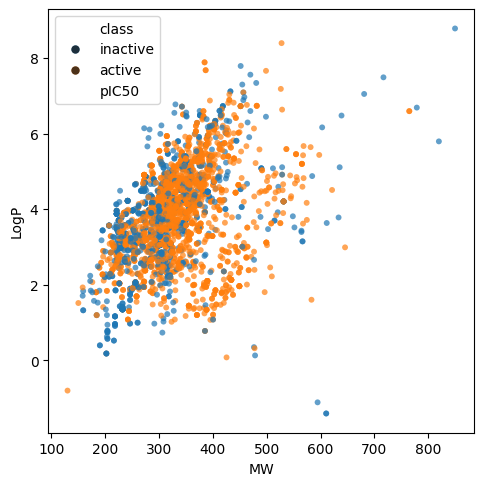

In [ ]:
# exploratory analysis of the chemical space
# MW vs logp
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df6, hue='class', size='pIC50', edgecolor='k', alpha=0.7)
# saveplot
plt.savefig('plot_MW_vs_LogP.png')

<Axes: xlabel='class', ylabel='count'>

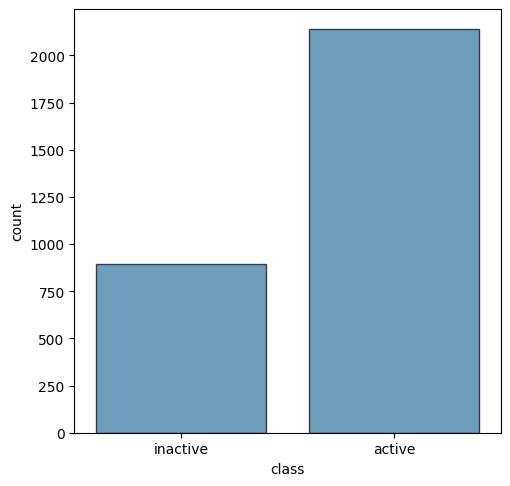

In [ ]:
# boxplot active vs inactive class
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x= 'class', data=df6,  edgecolor='k', alpha=0.7)

In [ ]:
# actives vs inactive values
actives = df6[df6['class'] == 'active']
inactives = df6[df6['class'] == 'inactive']
actives,inactives.shape

(     molecule_chembl_id                                   canonical_smiles  \
 1          CHEMBL431859      CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21   
 2          CHEMBL113637             CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21   
 3          CHEMBL112021                 Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21   
 4           CHEMBL41761             CCn1ccc2cc(C(c3ccc(F)cc3)n3ccnc3)ccc21   
 5          CHEMBL111868          Cn1cc(C(c2ccc(F)cc2)n2ccnc2)c2cc(Br)ccc21   
 ...                 ...                                                ...   
 3014       CHEMBL199334  COc1ccc2cc(C(c3ccc([N+](=O)[O-])cc3)n3cncn3)oc2c1   
 3015       CHEMBL371663            CCc1ccc(C(c2cc3ccc(OC)cc3o2)n2cncn2)cc1   
 3016      CHEMBL5438879                     N#Cc1ccccc1-c1cccc(Cn2cncn2)c1   
 3018      CHEMBL5431850    N#Cc1ccc(N(CCCc2ccc(OS(N)(=O)=O)cc2)n2cnnc2)cc1   
 3027       CHEMBL350072                           Cc1ccc(C2CCCc3cncn32)cc1   
 
        class  activity       MW     LogP  NumHDon

<Axes: xlabel='class', ylabel='pIC50'>

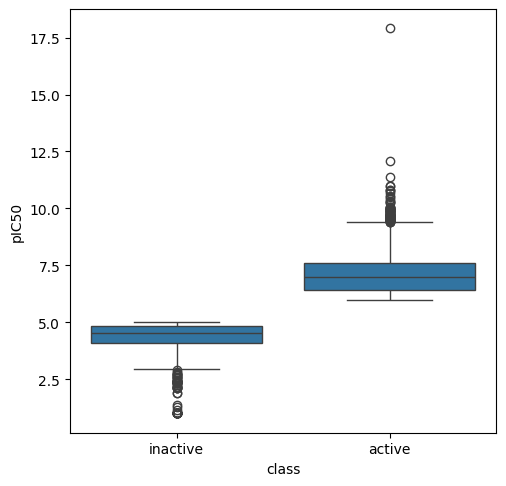

In [ ]:
# boxplot for PIC50
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x= 'class', y='pIC50', data=df6)

Statistical analysis | Mann-Whitney U Test

In [ ]:
!pip install scipy

In [ ]:
def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu

# seed the random number generator
  seed(1)

# actives and inactives
  selection = [descriptor, 'class']
  df = df6[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]

  selection = [descriptor, 'class']
  df = df6[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]

# compare samples
  stat, p = mannwhitneyu(active, inactive)
  #print('Statistics=%.3f, p=%.3f' % (stat, p))
  # interpret
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'

  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results


In [ ]:
# PIC50
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,1917786.0,0.0,0.05,Different distribution (reject H0)


<Axes: xlabel='class', ylabel='MW'>

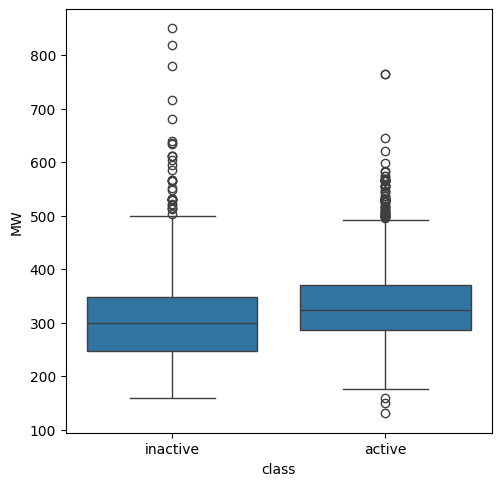

In [ ]:
# plot mw
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x= 'class', y='MW', data=df6)

In [ ]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,1174951.5,1.032647e-22,0.05,Different distribution (reject H0)


<Axes: xlabel='class', ylabel='LogP'>

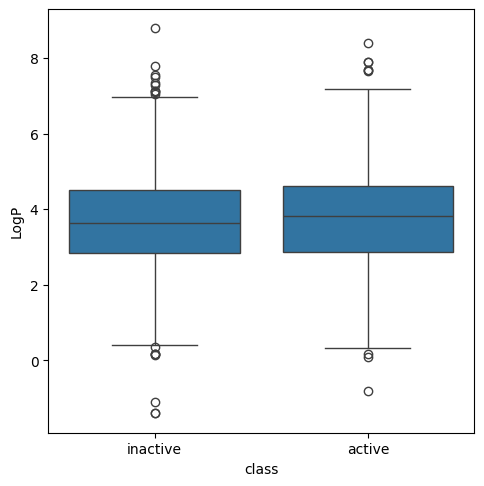

In [ ]:
# plot logp
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x= 'class', y='LogP', data=df6)


In [ ]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,1007446.0,0.02751,0.05,Different distribution (reject H0)


<Axes: xlabel='class', ylabel='NumHDonors'>

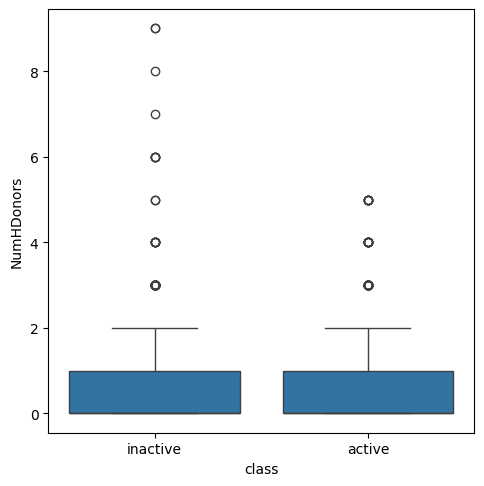

In [ ]:
# plot numhdonors
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x= 'class', y='NumHDonors', data=df6)

In [ ]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,844291.0,2.687641e-09,0.05,Different distribution (reject H0)


<Axes: xlabel='class', ylabel='NumHAcceptors'>

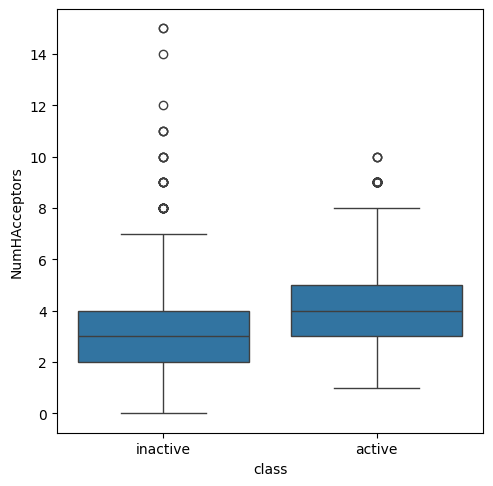

In [ ]:
# plot numhacceptors
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x= 'class', y='NumHAcceptors', data=df6)

In [ ]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,1124690.0,1.670432e-14,0.05,Different distribution (reject H0)


Lipinski's descriptors


All of the 4 Lipinski's descriptors exhibited statistically significant difference between the actives and inactives accept for logp



Pubchem Descriptors

In [ ]:
# ! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.zip
# ! wget https://github.com/dataprofessor/bioinformatics/raw/master/padel.sh

In [ ]:
# ! unzip padel.zip

In [ ]:
# selection = ['canonical_smiles','molecule_chembl_id']
# df3_selection = df6[selection]
# df3_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [ ]:
# ! cat molecule.smi | head -5

In [ ]:
# ! cat padel.sh

In [ ]:
# ! bash padel.sh

Morgan Fingerprints

In [ ]:
# ── Morgan fingerprints generation (replaces PubChem descriptors) ──

# RDKit imports
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
from tqdm import tqdm

def generate_morgan_fingerprints(smiles_list, radius=2, n_bits=2048):
    """
    Generate Morgan fingerprints for a list of SMILES strings.

    Parameters:
    - smiles_list: iterable of SMILES strings
    - radius: circular fingerprint radius (default=2)
    - n_bits: length of the bit vector (default=2048)

    Returns:
    - pandas.DataFrame of shape (len(smiles_list), n_bits)
    """
    fps = []
    for smi in tqdm(smiles_list, desc="Generating Morgan fingerprints"):
        mol = Chem.MolFromSmiles(smi)
        if mol:
            fp_vect = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
            fps.append(list(fp_vect))
        else:
            fps.append([0] * n_bits)
    cols = [f"FP_{i}" for i in range(n_bits)]
    return pd.DataFrame(fps, columns=cols)

# Load your preprocessed bioactivity data
# df5 = pd.read_csv('bioactivty_data_preprocessed_class.csv')  # adjust filename if needed

# Generate Morgan fingerprints
morgan_df = generate_morgan_fingerprints(df6['canonical_smiles'], radius=2, n_bits=2048)

# Combine with existing data
df_combined = pd.concat([df5.reset_index(drop=True), morgan_df.reset_index(drop=True)], axis=1)

# Save the new dataset
df_combined.to_csv('bioactivity_with_morgan_fps.csv', index=False)

print("Saved bioactivity_with_morgan_fps.csv with shape", df_combined.shape)


Generating Morgan fingerprints:   0%|          | 0/3035 [00:00<?, ?it/s][13:19:40] DEPRECATION WARNING: please use MorganGenerator
[13:19:40] DEPRECATION WARNING: please use MorganGenerator
[13:19:40] DEPRECATION WARNING: please use MorganGenerator
[13:19:40] DEPRECATION WARNING: please use MorganGenerator
[13:19:40] DEPRECATION WARNING: please use MorganGenerator
[13:19:40] DEPRECATION WARNING: please use MorganGenerator
[13:19:40] DEPRECATION WARNING: please use MorganGenerator
[13:19:40] DEPRECATION WARNING: please use MorganGenerator
[13:19:40] DEPRECATION WARNING: please use MorganGenerator
[13:19:40] DEPRECATION WARNING: please use MorganGenerator
[13:19:40] DEPRECATION WARNING: please use MorganGenerator
[13:19:40] DEPRECATION WARNING: please use MorganGenerator
[13:19:40] DEPRECATION WARNING: please use MorganGenerator
[13:19:40] DEPRECATION WARNING: please use MorganGenerator
[13:19:40] DEPRECATION WARNING: please use MorganGenerator
[13:19:40] DEPRECATION WARNING: please use 

Saved bioactivity_with_morgan_fps.csv with shape (3035, 2053)


In [ ]:
df4_x = pd.read_csv('bioactivity_with_morgan_fps.csv')
df4_x

,molecule_chembl_id,canonical_smiles,standard_value,class,activity,FP_0,FP_1,FP_2,FP_3,FP_4,...,FP_2038,FP_2039,FP_2040,FP_2041,FP_2042,FP_2043,FP_2044,FP_2045,FP_2046,FP_2047
0,CHEMBL2111947,C[C@]12CC[C@H]3[C@@H](CC=C4C[C@@H](O)CC[C@@]43...,5.000000e+04,inactive,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL431859,CCn1c(C(c2ccc(F)cc2)n2ccnc2)c(C)c2cc(Br)ccc21,2.380000e+02,active,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL113637,CCn1cc(C(c2ccc(F)cc2)n2ccnc2)c2ccccc21,5.700000e+01,active,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL112021,Clc1ccccc1Cn1cc(Cn2ccnc2)c2ccccc21,5.400000e+01,active,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL41761,CCn1ccc2cc(C(c3ccc(F)cc3)n3ccnc3)ccc21,4.100000e+01,active,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3030,CHEMBL5401971,FC(F)(F)c1ccc(C(CCCc2c[nH]cn2)c2ccc(C(F)(F)F)c...,6.266139e+08,inactive,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3031,CHEMBL5397559,Nc1ccc(C(CCCc2c[nH]cn2)c2ccc(N)cc2)cc1,9.057326e+08,inactive,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3032,CHEMBL5434818,Fc1ccc(C(CCCCc2ccccc2)c2c[nH]cn2)cc1,9.977001e+08,inactive,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3033,CHEMBL5419948,Fc1ccc(C(CCn2cncn2)c2ccc(F)cc2)cc1,9.682779e+08,inactive,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df4_x = df4_x.drop(columns=['canonical_smiles','molecule_chembl_id','standard_value','class','activity'])
df4_x

,FP_0,FP_1,FP_2,FP_3,FP_4,FP_5,FP_6,FP_7,FP_8,FP_9,...,FP_2038,FP_2039,FP_2040,FP_2041,FP_2042,FP_2043,FP_2044,FP_2045,FP_2046,FP_2047
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3030,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3031,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3032,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3033,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Preparing the X and Y Data Matrices

In [ ]:
# df3_X= pd.read_csv('/content/sample_data/descriptors_output (1).csv')

In [ ]:
# df3_X = pd.read_csv('descriptors_output.csv')

In [ ]:
# df3_X

In [ ]:
# df3_X = df3_X.drop(columns=['Name'])
# df3_X

Y variable

In [ ]:
df6 = pd.read_csv('bioactivity_data_3class_pIC50.csv')

In [ ]:
# df6 = pd.read_csv('/content/bioactivty_data_preprocessed_class.csv')

In [ ]:
df3_Y = df6['activity']
df3_Y

,activity
0,0
1,1
2,1
3,1
4,1
...,...
3030,0
3031,0
3032,0
3033,0


In [ ]:

# df3_Y = df5['pIC50']
# df3_Y

In [ ]:
dataset4 = pd.concat([df4_x,df3_Y], axis=1)
dataset4

,FP_0,FP_1,FP_2,FP_3,FP_4,FP_5,FP_6,FP_7,FP_8,FP_9,...,FP_2039,FP_2040,FP_2041,FP_2042,FP_2043,FP_2044,FP_2045,FP_2046,FP_2047,activity
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3030,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3031,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3032,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3033,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# dataset3 = pd.concat([df3_X,df3_Y], axis=1)
# dataset3

In [ ]:
# dataset3.to_csv('bioactivity_data_3class_pIC50_pubchem_fp.csv', index=False)

In [ ]:
# dataset3.to_csv('bioactivity_data_descriptors_activity_fp.csv', index=False)

In [ ]:
dataset4.to_csv('bioactivity_data_descriptors_morgan.csv', index=False)

MODEL BUILDING

In [ ]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,  matthews_corrcoef, roc_curve, auc, RocCurveDisplay, f1_score, precision_score, recall_score,roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")


In [ ]:
# Classifiers
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# df = pd.read_csv('bioactivity_data_descriptors_activity_fp.csv')


In [ ]:
df=pd.read_csv('bioactivity_data_descriptors_morgan.csv')

In [ ]:
# df = pd.read_csv('/content/bioactivity_data_3class_activity_activity_fp.csv')

input features

In [ ]:
X = df.drop('activity', axis=1)
X

,FP_0,FP_1,FP_2,FP_3,FP_4,FP_5,FP_6,FP_7,FP_8,FP_9,...,FP_2038,FP_2039,FP_2040,FP_2041,FP_2042,FP_2043,FP_2044,FP_2045,FP_2046,FP_2047
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3030,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3031,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3032,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3033,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


output features

In [ ]:
# Y = df.pIC50
# Y

In [ ]:
Y = df.activity
Y

,activity
0,0
1,1
2,1
3,1
4,1
...,...
3030,0
3031,0
3032,0
3033,0


In [ ]:
X.shape

(3035, 2048)

In [ ]:
Y.shape

(3035,)

In [ ]:
Y.value_counts()

,count
activity,
1,2138
0,897


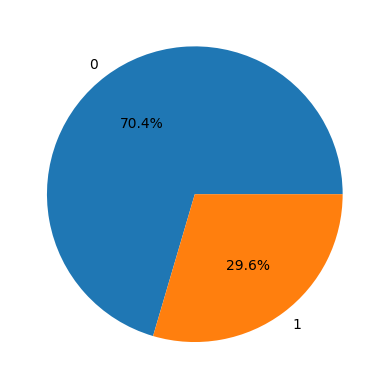

In [ ]:
plt.pie(Y.value_counts(), labels=Y.unique(), autopct='%1.1f%%')
plt.savefig('unbalanced_class_pie_chart.png')
plt.show()

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X, Y = smote.fit_resample(X, Y)

Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7e74e149b7e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: /usr/local/lib/python3.11/dist-packages/numpy.libs/libscipy_openblas64_-99b71e

In [ ]:
Y.value_counts()

,count
activity,
0,2138
1,2138


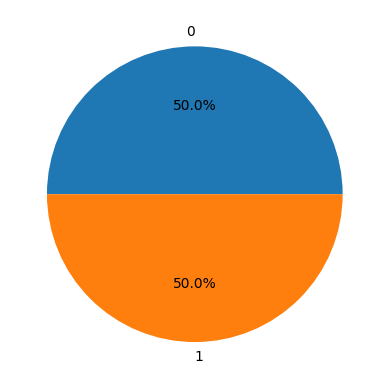

In [ ]:
plt.pie(Y.value_counts(), labels=Y.unique(), autopct='%1.1f%%')
plt.savefig('balanced_class__pie_chart.png')
plt.show()

Remove low variance

In [ ]:
from sklearn.feature_selection import VarianceThreshold
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))
X = selection.fit_transform(X)

In [ ]:
# save selection
import pickle
pickle.dump(selection, open('variance_threshold.pkl', 'wb'))

In [ ]:
X.shape

(4276, 24)

split dataset

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
X_train.shape, Y_train.shape

((3420, 24), (3420,))

In [ ]:
X_test.shape, Y_test.shape

((856, 24), (856,))

Random Forest

In [ ]:
rf = RandomForestClassifier(n_estimators=120, random_state = 42)
rf.fit(X_train, Y_train)
y_pred = rf.predict(X_test)

# evaluate model
accuracy = accuracy_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred, average='macro')
mcc = matthews_corrcoef(Y_test, y_pred)
Recall = recall_score(Y_test, y_pred, average='macro')
Precision = precision_score(Y_test, y_pred, average='macro')


# Print the results
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {Precision:.4f}")
print(f"Recall:    {Recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"MCC:       {mcc:.4f}")



Accuracy:  0.8458
Precision: 0.8460
Recall:    0.8461
F1 Score:  0.8458
MCC:       0.6920


External Testing

In [ ]:
# save rf
import pickle
pickle.dump(rf, open('rf.pkl', 'wb'))
# save selection
import pickle
pickle.dump(selection, open('variance_threshold.pkl', 'wb'))

In [ ]:
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
import joblib

# Load feature selector and model
selector = joblib.load("variance_threshold.pkl")
model = joblib.load("rf.pkl")

def smiles_to_morgan(smiles, radius=2, n_bits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError(f"Invalid SMILES: {smiles}")
    return AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
def predict_activity(named_smiles_list):
    fingerprints = []
    names = []
    valid_smiles = []

    for name, smi in named_smiles_list:
        try:
            fp = smiles_to_morgan(smi)
            fingerprints.append(np.array(fp))
            names.append(name)
            valid_smiles.append(smi)
        except ValueError as e:
            print(e)

    if not fingerprints:
        print("No valid SMILES to predict.")
        return

    X_full = np.array(fingerprints)

    # Transform using the saved selector (to reduce from 2048 to 55 features)
    X = selector.transform(X_full)

    probas = model.predict_proba(X)
    preds = model.predict(X)

    results = pd.DataFrame({
        "Name": names,
        "SMILES": valid_smiles,
        "Prediction": ["Active" if p == 1 else "Inactive" for p in preds],
        "Confidence": np.max(probas, axis=1)
    })

    return results


test_smiles = [
    ("Anastrozole", "CC(C)(C#N)C1=CC=CC=C1N2C=CN=N2"),
    ("Letrozole", "CC(C#N)C1=CC=C(C=C1)C(C#N)C2=CC=CC=N2"),
    ("Exemestane", "CC12CCC3C(C1CCC2=O)CCC4=C3C=CC(=C4)C#C"),
    ("Formestane", "CC12CCC3C(C1CCC2=O)CCC4=CC(=O)CCC34O"),
    ("Vorozole", "CC1=CN=C(N=C1)C2=CC=CC=C2Cl")
]

results_df = predict_activity(test_smiles)
print(results_df)


          Name                                  SMILES Prediction  Confidence
0  Anastrozole          CC(C)(C#N)C1=CC=CC=C1N2C=CN=N2   Inactive    0.764544
1    Letrozole   CC(C#N)C1=CC=C(C=C1)C(C#N)C2=CC=CC=N2   Inactive    0.785317
2   Exemestane  CC12CCC3C(C1CCC2=O)CCC4=C3C=CC(=C4)C#C   Inactive    0.573894
3   Formestane    CC12CCC3C(C1CCC2=O)CCC4=CC(=O)CCC34O   Inactive    0.835763
4     Vorozole             CC1=CN=C(N=C1)C2=CC=CC=C2Cl   Inactive    0.880819


[13:20:15] DEPRECATION WARNING: please use MorganGenerator
[13:20:15] DEPRECATION WARNING: please use MorganGenerator
[13:20:15] DEPRECATION WARNING: please use MorganGenerator
[13:20:15] DEPRECATION WARNING: please use MorganGenerator
[13:20:15] DEPRECATION WARNING: please use MorganGenerator


In [ ]:
# #  Hyperparameter tunning using GridSearchCV for rf
# from sklearn.model_selection import GridSearchCV
# param_grid = {
#     'n_estimators': [100,120,150],
#     'max_depth': [None, 8,10],
#     'min_samples_split': [2,3],
#     'min_samples_leaf': [1,2],
#     'max_features': ['auto', 'sqrt'],
#     'bootstrap': [True, False]
# }

# grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=10, scoring ='accuracy', verbose =1, n_jobs=1 )
# grid_search.fit(X_train, Y_train)
# best_params = grid_search.best_params_
# print(best_params)
# print(grid_search.best_score_)
# y_pred = grid_search.predict(X_test)

# # Lists to store metrics
# accuracies = []
# precisions = []
# recalls = []
# f1_scores = []
# mccs = []
# # compute metrics
# accuracies.append(accuracy_score(Y_test, y_pred))
# precisions.append(precision_score(Y_test, y_pred, average='macro'))
# recalls.append(recall_score(Y_test, y_pred, average='macro'))
# f1_scores.append(f1_score(Y_test, y_pred, average='macro'))
# mccs.append(matthews_corrcoef(Y_test, y_pred))
# # print  metrics
# print(f"Accuracy:  {accuracies[-1]:.4f}")
# print(f"Precision: {precisions[-1]:.4f}")
# print(f"Recall:    {recalls[-1]:.4f}")
# print(f"F1 Score:  {f1_scores[-1]:.4f}")
# print(f"MCC:       {mccs[-1]:.4f}")

ExtraTrees

In [ ]:
# Intialize and train the classifier

et = ExtraTreesClassifier(n_estimators=120,max_depth=8, random_state = 42)
et.fit(X_train, Y_train)

# make predictions
y_pred = et.predict(X_test)

# evaluate model
accuracy = accuracy_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred, average='macro')
mcc = matthews_corrcoef(Y_test, y_pred)
Recall = recall_score(Y_test, y_pred, average='macro')
Precision = precision_score(Y_test, y_pred, average='macro')


# print results
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {Precision:.4f}")
print(f"Recall:    {Recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"MCC:       {mcc:.4f}")

Accuracy:  0.8236
Precision: 0.8237
Recall:    0.8233
F1 Score:  0.8234
MCC:       0.6470


In [ ]:
# save ExtraTrees
import pickle
pickle.dump(et, open('et.pkl', 'wb'))

In [ ]:
# # Hyperparameter tuning using gridsearchcv
# param_grid = {
#     'n_estimators': [100,120,150],
#     'max_depth': [None,8,10],
#     'min_samples_split': [2,3],
#     'min_samples_leaf': [1,2],
#     'max_features': ['auto', 'sqrt'],
#     'bootstrap': [True, False]
# }
# grid_search = GridSearchCV(estimator=et, param_grid=param_grid, cv=10, scoring ='accuracy', verbose =1, n_jobs=1 )
# grid_search.fit(X_train, Y_train)
# best_params = grid_search.best_params_
# print(best_params)
# print(grid_search.best_score_)
# y_pred= grid_search.predict(X_test)

# # Lists to store metrics
# accuracies = []
# precisions = []
# recalls = []
# f1_scores = []
# mccs = []
# # compute metrics
# accuracies.append(accuracy_score(Y_test, y_pred))
# precisions.append(precision_score(Y_test, y_pred, average='macro'))
# recalls.append(recall_score(Y_test, y_pred, average='macro'))
# f1_scores.append(f1_score(Y_test, y_pred, average='macro'))
# mccs.append(matthews_corrcoef(Y_test, y_pred))
# # print  metrics
# print(f"Accuracy:  {accuracies[-1]:.4f}")
# print(f"Precision: {precisions[-1]:.4f}")
# print(f"Recall:    {recalls[-1]:.4f}")
# print(f"F1 Score:  {f1_scores[-1]:.4f}")
# print(f"MCC:       {mccs[-1]:.4f}")



KNN

In [ ]:
# Initialize and train the classifier
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, Y_train)

# Make predictions
y_pred = knn.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred, average='macro')
recall = recall_score(Y_test, y_pred, average='macro')
f1 = f1_score(Y_test, y_pred, average='macro')
mcc = matthews_corrcoef(Y_test, y_pred)
roc_auc = roc_auc_score(Y_test, y_pred)

# Print the results
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"MCC:       {mcc:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

Accuracy:  0.8084
Precision: 0.8119
Recall:    0.8072
F1 Score:  0.8074
MCC:       0.6191
ROC AUC:   0.8072


In [ ]:
# save knn
import pickle
pickle.dump(knn, open('knn.pkl', 'wb'))

In [ ]:
# # Hyperparameter tunning with gridsearchcv
# param_grid = {
#     'n_neighbors': [3,5,7,9],
#     'weights': ['uniform', 'distance'],
#     'p': [1,2],
#     'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
# }
# grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=10, scoring ='accuracy', verbose =1, n_jobs=1)
# grid_search.fit(X_train, Y_train)
# best_params = grid_search.best_params_
# print(best_params)
# print(grid_search.best_score_)
# y_pred = grid_search.predict(X_test)

# # Lists to store metrics
# accuracies = []
# precisions = []
# recalls = []
# f1_scores = []
# mccs = []
# # compute metrics
# accuracies.append(accuracy_score(Y_test, y_pred))
# precisions.append(precision_score(Y_test, y_pred, average='macro'))
# recalls.append(recall_score(Y_test, y_pred, average='macro'))
# f1_scores.append(f1_score(Y_test, y_pred, average='macro'))
# mccs.append(matthews_corrcoef(Y_test, y_pred))
# # print  metrics
# print(f"Accuracy:  {accuracies[-1]:.4f}")
# print(f"Precision: {precisions[-1]:.4f}")
# print(f"Recall:    {recalls[-1]:.4f}")
# print(f"F1 Score:  {f1_scores[-1]:.4f}")
# print(f"MCC:       {mccs[-1]:.4f}")

AdaBoost

In [ ]:
# Initialize and train the classifier

adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost.fit(X_train, Y_train)

# make Predictions
y_pred = adaboost.predict(X_test)

# evaluate the model
accuracy = accuracy_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred, average='macro')
mcc = matthews_corrcoef(Y_test, y_pred)
recall = recall_score(Y_test, y_pred, average='macro')
precision = precision_score(Y_test, y_pred, average='macro')
roc_auc = roc_auc_score(Y_test, y_pred)

# print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"MCC: {mcc:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

Accuracy: 0.75
F1 Score: 0.75
MCC: 0.51
Recall: 0.75
Precision: 0.76
ROC AUC: 0.75


In [ ]:
# save adaboost
import pickle
pickle.dump(adaboost, open('adaboost.pkl', 'wb'))

In [ ]:
# # Hyperparameter tunning using gridsearchcv
# param_grid = {
#     'n_estimators': [100,120,150],
#     'learning_rate': [0.01,0.1,1],
#     'algorithm': ['SAMME', 'SAMME.R'],
#     'random_state': [42]

# }
# grid_search = GridSearchCV(estimator=adaboost, param_grid=param_grid, cv=10, scoring ='accuracy', verbose =1, n_jobs=1)
# grid_search.fit(X_train, Y_train)
# best_params = grid_search.best_params_
# print(best_params)
# print(grid_search.best_score_)
# y_pred = grid_search.predict(X_test)

# # Lists to store metrics
# accuracies = []
# precisions = []
# recalls = []
# f1_scores = []
# mccs = []
# # compute metrics
# accuracies.append(accuracy_score(Y_test, y_pred))
# precisions.append(precision_score(Y_test, y_pred, average='macro'))
# recalls.append(recall_score(Y_test, y_pred, average='macro'))
# f1_scores.append(f1_score(Y_test, y_pred, average='macro'))
# mccs.append(matthews_corrcoef(Y_test, y_pred))
# # print  metrics
# print(f"Accuracy:  {accuracies[-1]:.4f}")
# print(f"Precision: {precisions[-1]:.4f}")
# print(f"Recall:    {recalls[-1]:.4f}")
# print(f"F1 Score:  {f1_scores[-1]:.4f}")
# print(f"MCC:       {mccs[-1]:.4f}")

Gradient Boost

In [ ]:
# Intialize and train the classifier

gb = GradientBoostingClassifier(n_estimators=100, random_state=42)
gb.fit(X_train, Y_train)

# make predictions
y_pred = gb.predict(X_test)

# evaluate model
accuracy = accuracy_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred, average='macro')
mcc = matthews_corrcoef(Y_test, y_pred)
Recall = recall_score(Y_test, y_pred, average='macro')
Precision = precision_score(Y_test, y_pred, average='macro')
roc_auc = roc_auc_score(Y_test, y_pred)

# print results
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"MCC:       {mcc:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

Accuracy:  0.7979
Precision: 0.7555
Recall:    0.7524
F1 Score:  0.7975
MCC:       0.5959
ROC AUC:   0.7973


In [ ]:
# save GradientBoosting
import pickle
pickle.dump(gb, open('gb.pkl', 'wb'))

In [ ]:
# # Hyperparameter tunning using gridsearchcv
# param_grid = {
#     'n_estimators': [100,120,150],
#     'learning_rate': [0.01,0.1,1],
#     'max_depth': [3,5,7],
#     'min_samples_split': [2,3],
#     'min_samples_leaf': [1,2],
#     'max_features': ['auto', 'sqrt'],
#     'subsample': [0.8,1.0]

# }
# grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=10, scoring ='accuracy', verbose =1, n_jobs=1)
# grid_search.fit(X_train, Y_train)
# best_params = grid_search.best_params_
# print(best_params)
# print(grid_search.best_score_)
# y_pred = grid_search.predict(X_test)

# # Lists to store metrics
# accuracies = []
# precisions = []
# recalls = []
# f1_scores = []
# mccs = []
# # compute metrics
# accuracies.append(accuracy_score(Y_test, y_pred))
# precisions.append(precision_score(Y_test, y_pred, average='macro'))
# recalls.append(recall_score(Y_test, y_pred, average='macro'))
# f1_scores.append(f1_score(Y_test, y_pred, average='macro'))
# mccs.append(matthews_corrcoef(Y_test, y_pred))
# # print  metrics
# print(f"Accuracy:  {accuracies[-1]:.4f}")
# print(f"Precision: {precisions[-1]:.4f}")
# print(f"Recall:    {recalls[-1]:.4f}")
# print(f"F1 Score:  {f1_scores[-1]:.4f}")
# print(f"MCC:       {mccs[-1]:.4f}")


Plots

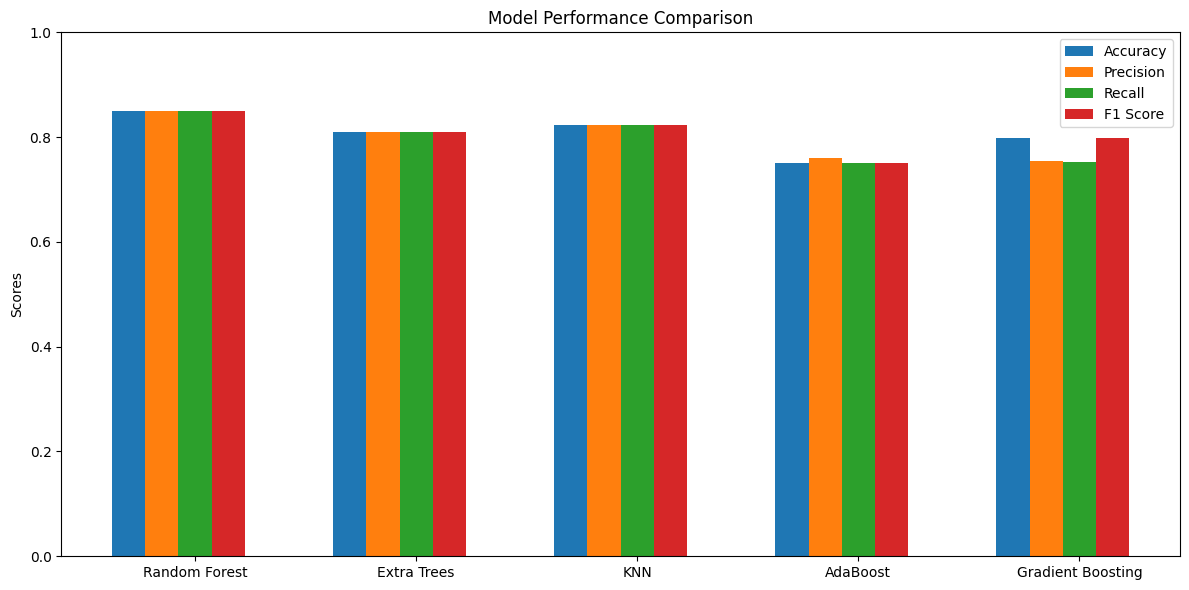

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Model names
models = ['Random Forest', 'Extra Trees', 'KNN', 'AdaBoost', 'Gradient Boosting']

# Metrics
accuracy = [0.8493, 0.8107, 0.8224, 0.75, 0.7991]
precision = [0.8497, 0.8107, 0.8228, 0.76, 0.7553]
recall = [0.8497, 0.8106, 0.8228, 0.75, 0.7525]
f1_score = [0.8493, 0.8106, 0.8224, 0.75, 0.7986]


x = np.arange(len(models))
width = 0.15

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - 2*width, accuracy, width, label='Accuracy')
bars2 = ax.bar(x - width, precision, width, label='Precision')
bars3 = ax.bar(x, recall, width, label='Recall')
bars4 = ax.bar(x + width, f1_score, width, label='F1 Score')

# Labeling
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
ax.set_ylim(0, 1)


plt.tight_layout()
plt.show()


In [ ]:
# Initialize and train the classifier

adaboost = AdaBoostClassifier(n_estimators=100, random_state=42)
adaboost.fit(X_train, Y_train)

# make Predictions
y_pred = adaboost.predict(X_test)

# evaluate the model
accuracy = accuracy_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred, average='macro')
mcc = matthews_corrcoef(Y_test, y_pred)
recall = recall_score(Y_test, y_pred, average='macro')
precision = precision_score(Y_test, y_pred, average='macro')
roc_auc = roc_auc_score(Y_test, y_pred)

# print the results
print(f"Accuracy: {accuracy:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"MCC: {mcc:.2f}")
print(f"Recall: {recall:.2f}")
print(f"Precision: {precision:.2f}")
print(f"ROC AUC: {roc_auc:.2f}")

TypeError: 'list' object is not callable

In [ ]:
rf_mcc = 0.6994
et_mcc = 0.6213
knn_mcc =   0.6456
adaboost_mcc = 0.6922
gb_mcc =  0.5983

model_names = ['Random Forest', 'Extra Trees', 'KNN', 'AdaBoost', 'Gradient Boosting']
mcc_scores = [rf_mcc, et_mcc, knn_mcc, adaboost_mcc, gb_mcc]

# Plotting
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, mcc_scores)

# Add text labels
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f"{yval:.2f}", ha='center', va='bottom')

plt.title('MCC Scores for Different Models')
plt.ylabel('Matthews Correlation Coefficient')
plt.ylim(0, 1.1)
# plt.grid(axis='y', alpha=0.7)
plt.tight_layout()
plt.savefig('mcc.png')
plt.show()



In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_test is the true label and these are the probability scores
# Make sure these are computed using .predict_proba(X_test)[:, 1]
model_scores = {
    "Random Forest": rf.predict_proba(X_test)[:, 1],
    "Extra Trees": et.predict_proba(X_test)[:, 1],
    "KNN": knn.predict_proba(X_test)[:, 1],
    "AdaBoost": adaboost.predict_proba(X_test)[:, 1],
    "Gradient Boosting": gb.predict_proba(X_test)[:, 1],
}

plt.figure(figsize=(10, 7))

for name, y_score in model_scores.items():
    fpr, tpr, _ = roc_curve(Y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# Plot random baseline
plt.plot([0, 1], [0, 1], 'k--', label='Random')

plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve_comparison.png", dpi=300)
plt.show()


In [ ]:
# save X_train and X_test
import pickle
pickle.dump(X_train, open('X_train.pkl', 'wb'))
pickle.dump(X_test, open('X_test.pkl', 'wb'))

APPLICABILITY DOMAIN

In [ ]:
# Combine X_train and X_test for PCA projection
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
X_all = np.vstack([X_train, X_test])
y_all = np.concatenate([['train'] * len(X_train), ['test'] * len(X_test)])

# Standardize descriptors
scaler = StandardScaler()
X_all_std = scaler.fit_transform(X_all)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_all_std)

# Plot
plt.figure(figsize=(10, 6))
for label, color in zip(['train', 'test'], ['blue', 'orange']):
    idxs = (y_all == label)
    plt.scatter(X_pca[idxs, 0], X_pca[idxs, 1], c=color, label=label, alpha=0.6, edgecolor='k')

plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.title("Applicability Domain: PCA of Standardized Descriptor Space")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("applicability_domain_pca.png", dpi=300)
plt.show()
